In [250]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from common import geo_to_cartesian_m, calculate_centroids, cartesian_to_geo

In [251]:
RADIUS_EARTH_KM = 6373.0
RADIUS_EARTH_M = RADIUS_EARTH_KM * 1000

In [252]:
df = pd.read_csv("data/mappers_processed.csv", nrows=10000)

In [253]:
data = np.concatenate([
    df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy() for prefix in ["target", "hotspot1", "hotspot2", "hotspot3"]
])
print(data.shape)

(40000, 2)


In [254]:
def haversine_np(lat_long_deg_1, lat_long_deg_2, radius:float=RADIUS_EARTH_KM):
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = np.sin((lat_2 - lat_1)/2)**2 + np.cos(lat_1)*np.cos(lat_2) * np.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * np.arcsin(np.sqrt(d))
    return arc_len

def k_means(data, k:int=50, num_iter:int=50, seed:int=42, trace: bool=False):
    np.random.seed(seed)

    n, d = data.shape
    # Pre-compute cartesian coordinates for each data point
    data_xyz_m = geo_to_cartesian_m(
        lat_long_alt=np.stack([data[:,0], data[:,1], np.zeros((n))], axis=1)
    )
    # Initialize centroids as random selection of data points
    centroids = data[np.random.choice(n, k, replace=False)] # k, d 
    diff = np.zeros((n,k))

    for _ in tqdm(range(num_iter), disable=not trace):
        # Assign centroids based on minimum haversine distance
        for i in range(k):
            diff[:, i] = haversine_np(data, centroids[np.newaxis, i,:])
        labels = diff.argmin(axis=1) # n,

        # Update the centroids to be the projected centroid of the members of each cluster
        for i in range(k):
            members_xyz_m = data_xyz_m[np.argwhere(labels==i), :]
            if members_xyz_m.shape[0] == 0:
                # empty cluster... don't update
                continue
            centroid_xyz_m = calculate_centroids(coordinates_xyz_m=members_xyz_m[:, :], project=True)
            centroid_lat_long = cartesian_to_geo(xyz_m=centroid_xyz_m)[:,:2]
            centroids[i] = centroid_lat_long
        
    return centroids

In [255]:
# Cluster
centroids = k_means(data, k=2000, trace=True)

100%|██████████| 50/50 [03:23<00:00,  4.06s/it]


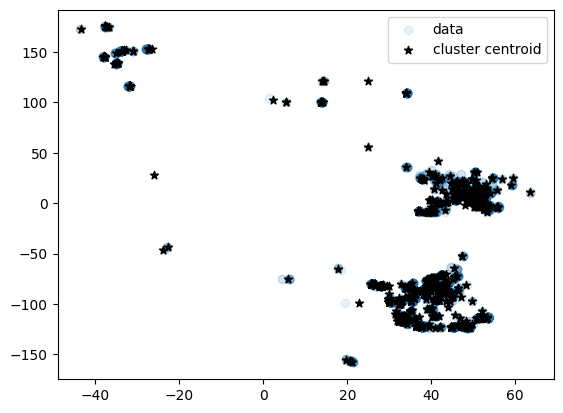

In [256]:
# Visualize clusters
subset = data[np.random.choice(data.shape[0], min(10000, data.shape[0]), replace=False), :]
plt.scatter(subset[:,0], subset[:,1], alpha=0.1, label="data")
plt.scatter(centroids[:,0], centroids[:,1], marker="*", color="k", label="cluster centroid")
plt.legend()
plt.show()